In [1]:
!mkdir -p data/house-prices

In [2]:
!unzip -o data/house-prices-advanced-regression-techniques.zip -d data/house-prices

Archive:  data/house-prices-advanced-regression-techniques.zip
  inflating: data/house-prices/data_description.txt  
  inflating: data/house-prices/sample_submission.csv  
  inflating: data/house-prices/test.csv  
  inflating: data/house-prices/train.csv  


In [3]:
from statistics import mean

import advertion
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm

seed = np.random.RandomState(31337)

In [4]:
trainset = pd.read_csv("data/house-prices/train.csv")

trainset.shape

(1460, 81)

In [5]:
testset = pd.read_csv("data/house-prices/test.csv")

testset.shape

(1459, 80)

In [6]:
trainset.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [7]:
# keep only numerical features
X_train = trainset.select_dtypes(include=["number"]).copy()
X_test = testset.select_dtypes(include=["number"]).copy()

In [8]:
# drop target variable from our training dataset
X_train = X_train.drop(["SalePrice"], axis=1)

In [9]:
X_train["_adval_label_"] = 0.0

In [10]:
X_test["_adval_label_"] = 1.0

In [11]:
# combine training & test datasets
combined_dataset = pd.concat([X_train, X_test], axis=0, ignore_index=True)

combined_dataset.shape

(2919, 38)

In [12]:
combined_dataset.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', '_adval_label_'],
      dtype='object')

In [13]:
# shuffle it
combined_dataset_shuffled = combined_dataset.sample(frac=1)

In [14]:
X = combined_dataset_shuffled.drop(["_adval_label_"], axis=1)

In [15]:
y = combined_dataset_shuffled["_adval_label_"]

In [16]:
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
classifier = xgb.XGBClassifier()

  0%|          | 0/5 [00:00<?, ?it/s]

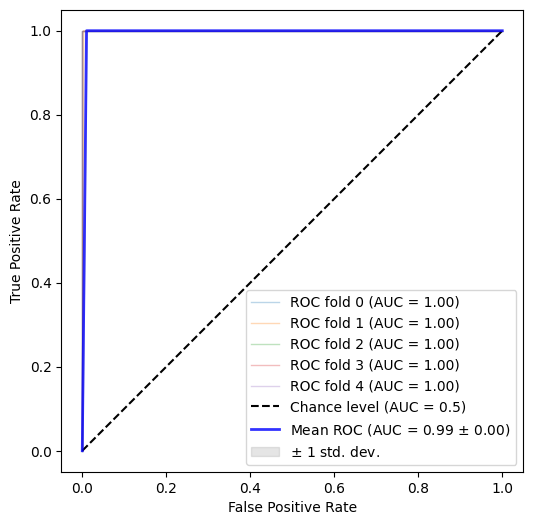

In [17]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))


for fold, (train, test) in tqdm([*enumerate(cv.split(X, y))]):
    classifier.fit(X.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test],
        y.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.axis("square")
ax.legend(loc="best")
plt.show()

In [18]:
aucs

[1.0, 0.9982876712328766, 1.0, 1.0, 1.0]

In [19]:
mean(aucs)

0.9996575342465753

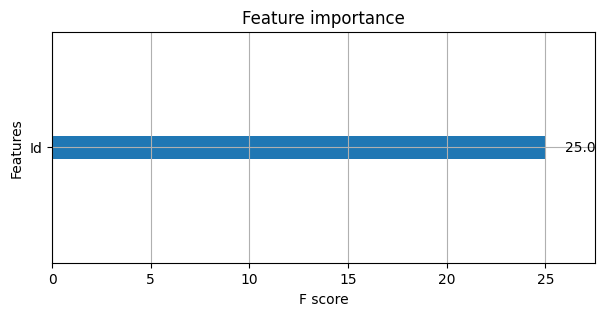

In [20]:
classifier = xgb.XGBClassifier(eval_metric="logloss")
classifier.fit(X, y)
fig, ax = plt.subplots(figsize=(7, 3))
xgb.plot_importance(classifier, ax=ax)
plt.show();

In [21]:
trainset

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [22]:
testset

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


It is apparent that a classifier can easily distinguish training from test instances via a very simple heuristic: `Id >= 1461`.

In [23]:
X = X.drop(["Id"], axis=1)

In [24]:
n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
classifier = xgb.XGBClassifier()

  0%|          | 0/5 [00:00<?, ?it/s]

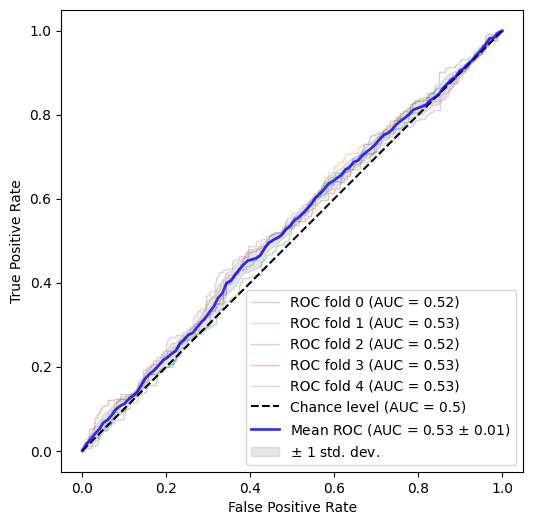

In [25]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))


for fold, (train, test) in tqdm([*enumerate(cv.split(X, y))]):
    classifier.fit(X.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test],
        y.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.axis("square")
ax.legend(loc="best")
plt.show()

In [26]:
aucs

[0.5219787952711578,
 0.5326398010883844,
 0.5170529179958716,
 0.5292620566710452,
 0.5295862166360683]

In [27]:
mean(aucs)

0.5261039575325055

### using the advertion package

In [28]:
advertion.validate(
    trainset=trainset,
    testset=testset,
    target="SalePrice",
)

INFO: Working only with available numerical features, categorical features are not yet supported.
INFO: Will try to identify adversarial features (see: https://advertion.readthedocs.io/en/0.1.0-alpha/adversarial-features)
INFO: Identified adversarial feature: [name: Id, statistic: 1.0, p-value: 0.0].
INFO: training and test datasets follow the same underlying distribution [mean ROC AUC: 0.512].


{'adversarial_features': ['Id'],
 'datasets_follow_same_distribution': True,
 'mean_roc_auc': 0.5120309454073187}